# Imports

In [1]:
import keras
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

# Latex settings block

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

# Load feature and label arrays from an npz file for training

In [ ]:
with np.load("root_files/combined_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

# Separate train signal and background events in dataframes

In [4]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

# All dels in this notebook are to clear up RAM

In [5]:
del feature_array, label_array

# Load feature and label arrays from an npz file for testing/validation

In [6]:
with np.load("root_files/combined_validate.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

# Separate test signal and background events in dataframes

In [7]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [8]:
del feature_array_test, label_array_test

# Just a renaming in case someone wants to do out some outlier removal
# The "_out" dataframes are supposed to have their outliers removed 

In [9]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

# View the shapes of the dataframes

In [10]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(9940631, 49)
(9940631, 49)
(3260972, 49)
(3260972, 49)


In [11]:
del bkg, sig, bkg_test, sig_test, df, df_test

# Sample background events equal to the amount of our available signal events for training and validation purposes
# The backgrounds events are generally a lot more but we want to keep the sets 50-50

In [12]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

# Check the the final shapes are indeed equal

In [13]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1511107, 49)
(1511107, 49)
(494538, 49)
(494538, 49)


# Plot 48/49 variable histograms into a grid
# Blue histograms are signal events and red are background events

  0%|          | 0/48 [00:00<?, ?it/s]

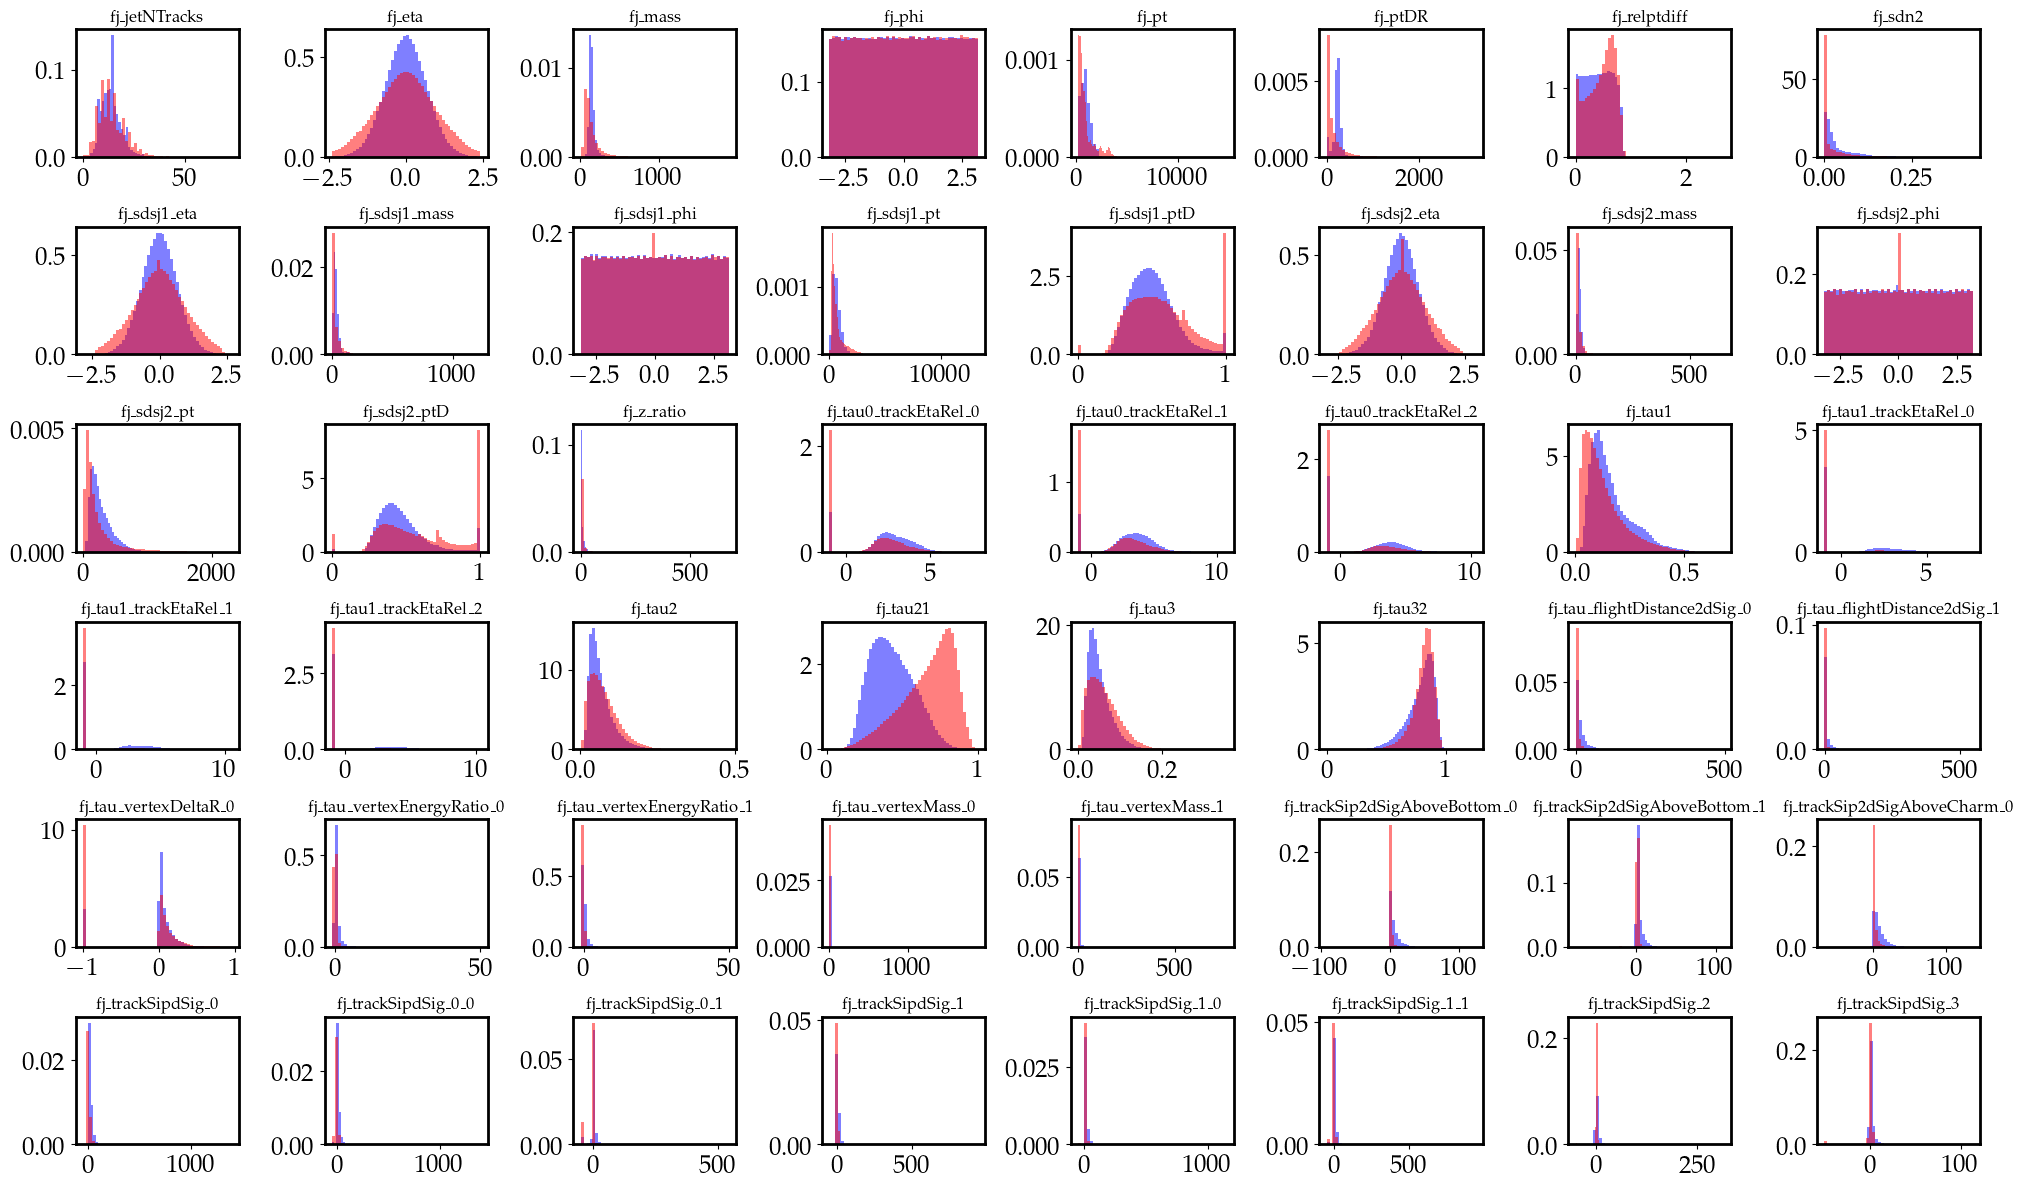

In [14]:
fig, axes = plt.subplots(6,8, figsize=(20,12))

features_to_plot = sig_train_out.columns.drop('fj_nSV')

for ax, label in tqdm(zip(axes.ravel(), features_to_plot), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('plots/hists.pdf')
plt.show()

# Plot correlation matrix of signal events in the training set

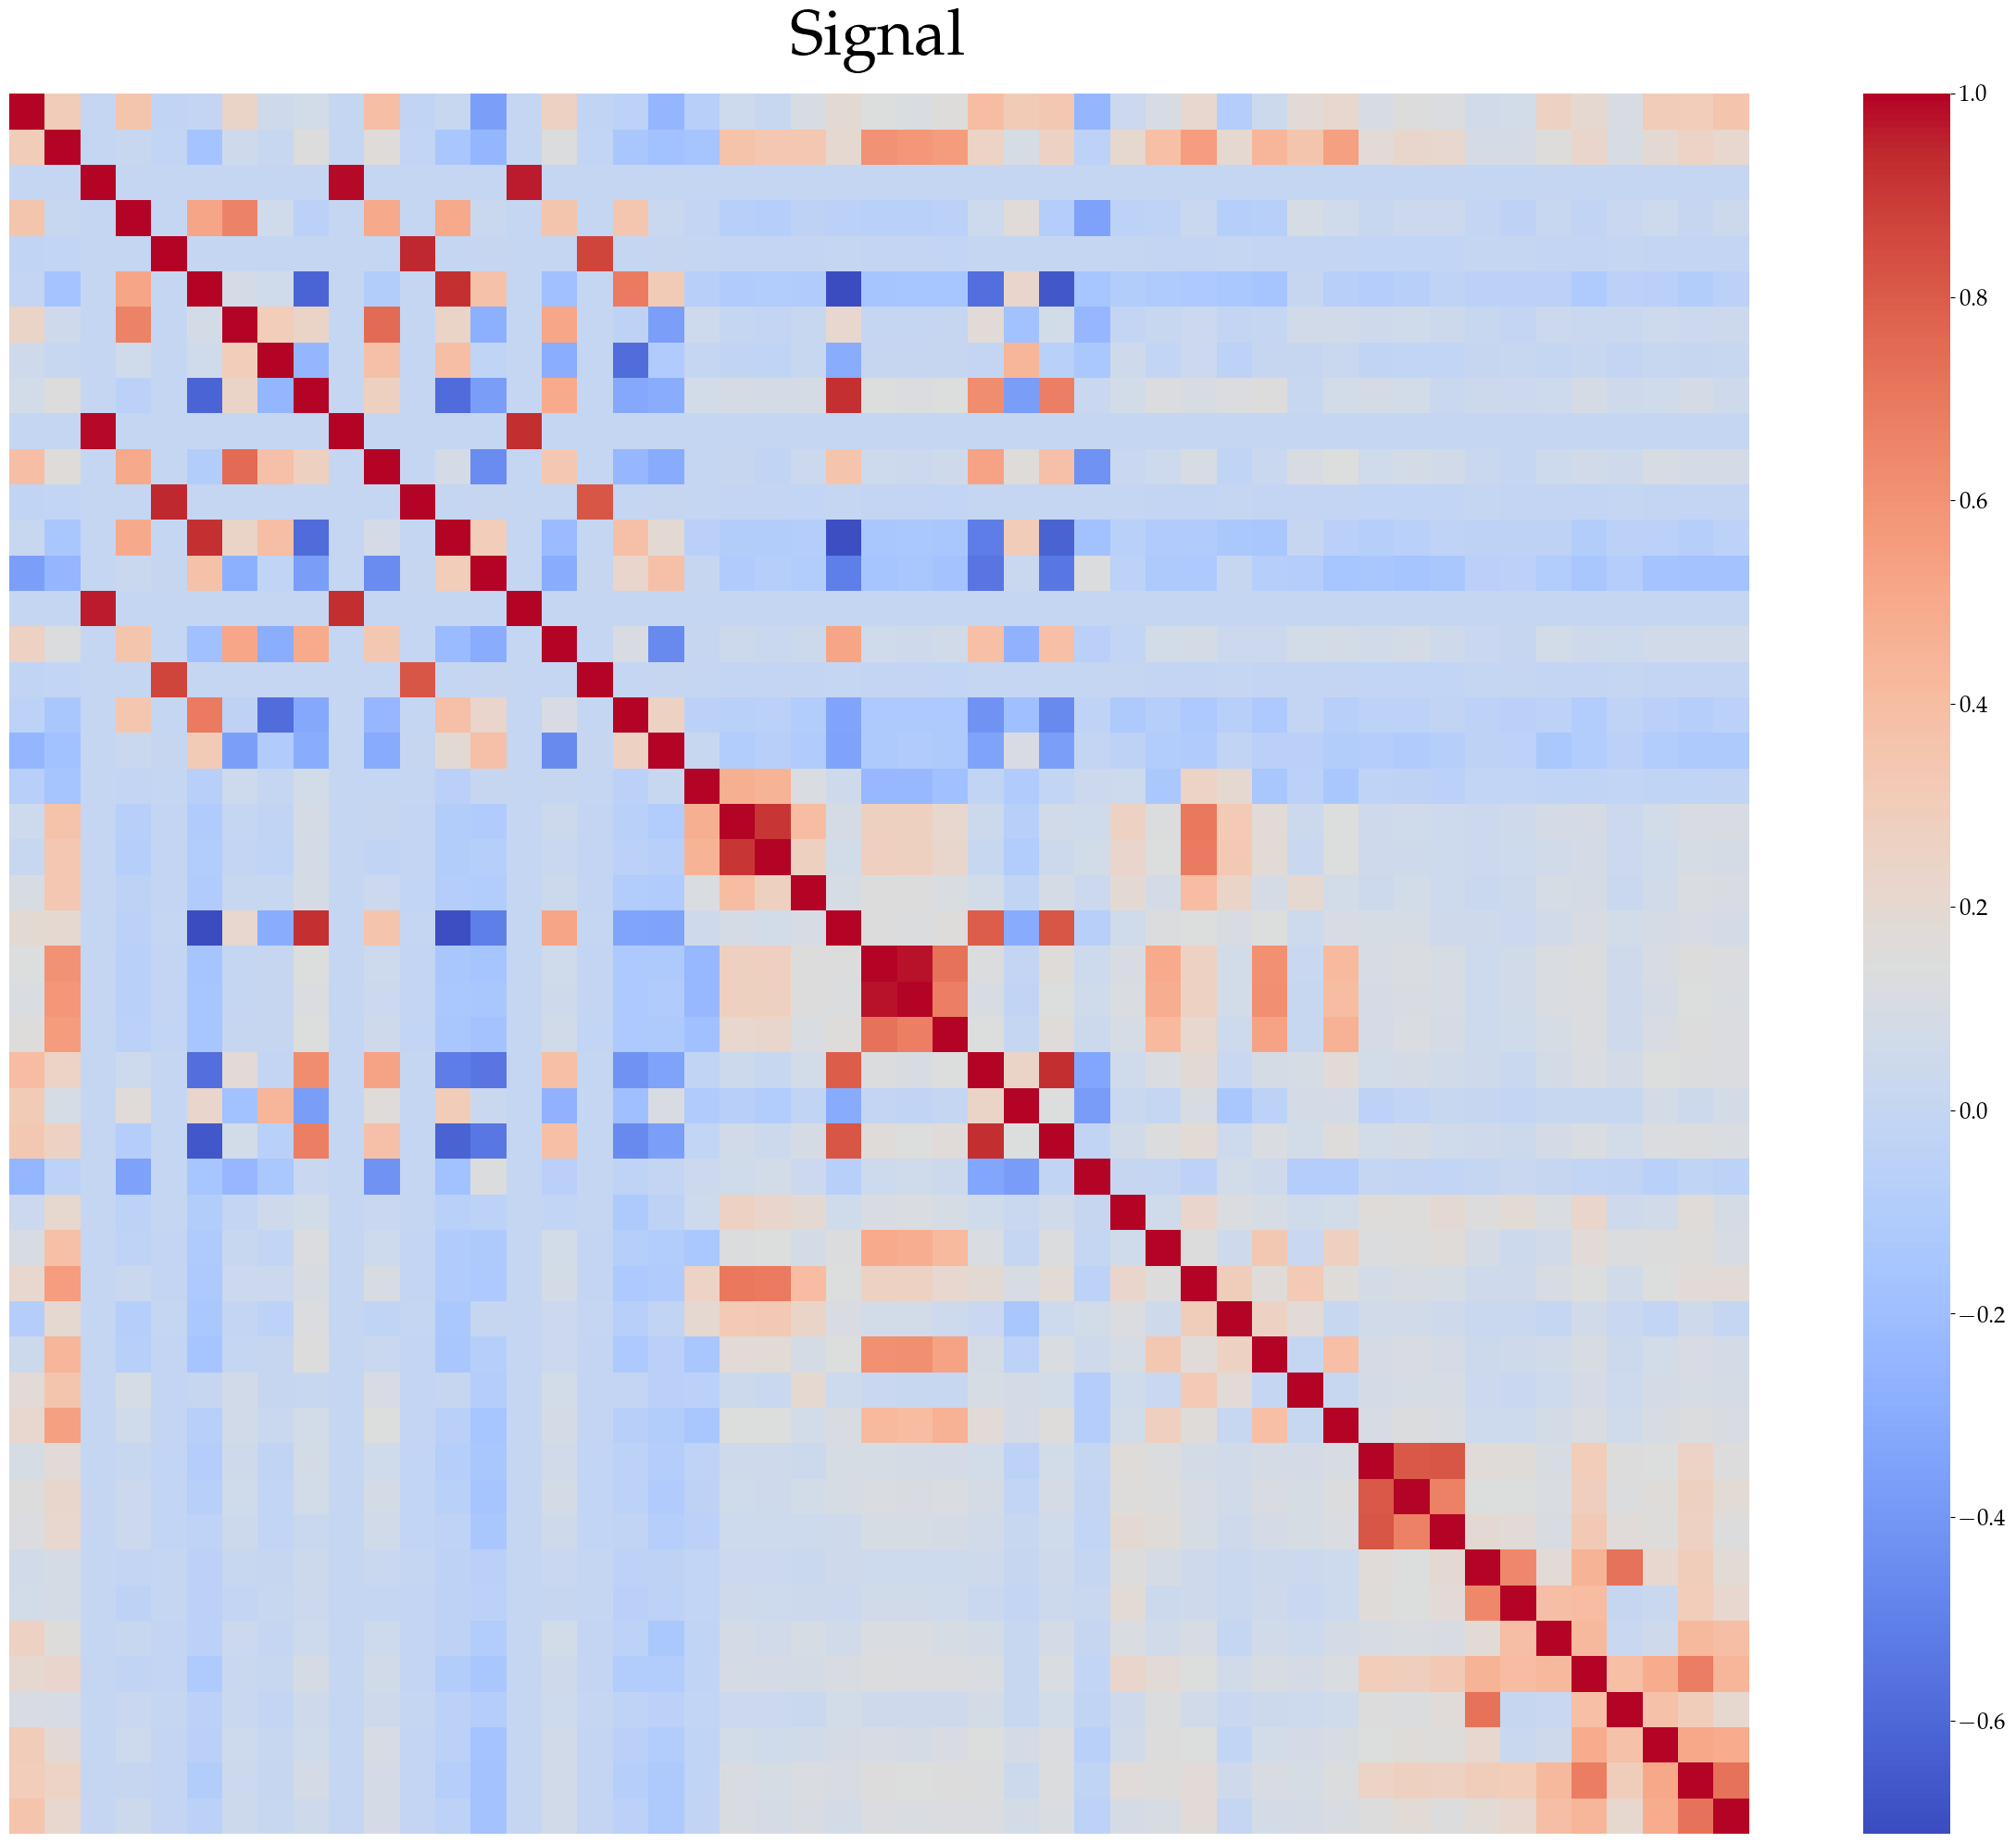

In [15]:
plt.figure(figsize=(25,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True,
            xticklabels=False, yticklabels=False)
plt.title('Signal', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_sig.pdf', bbox_inches='tight')
plt.show()

# Plot correlation matrix of background events in the training set

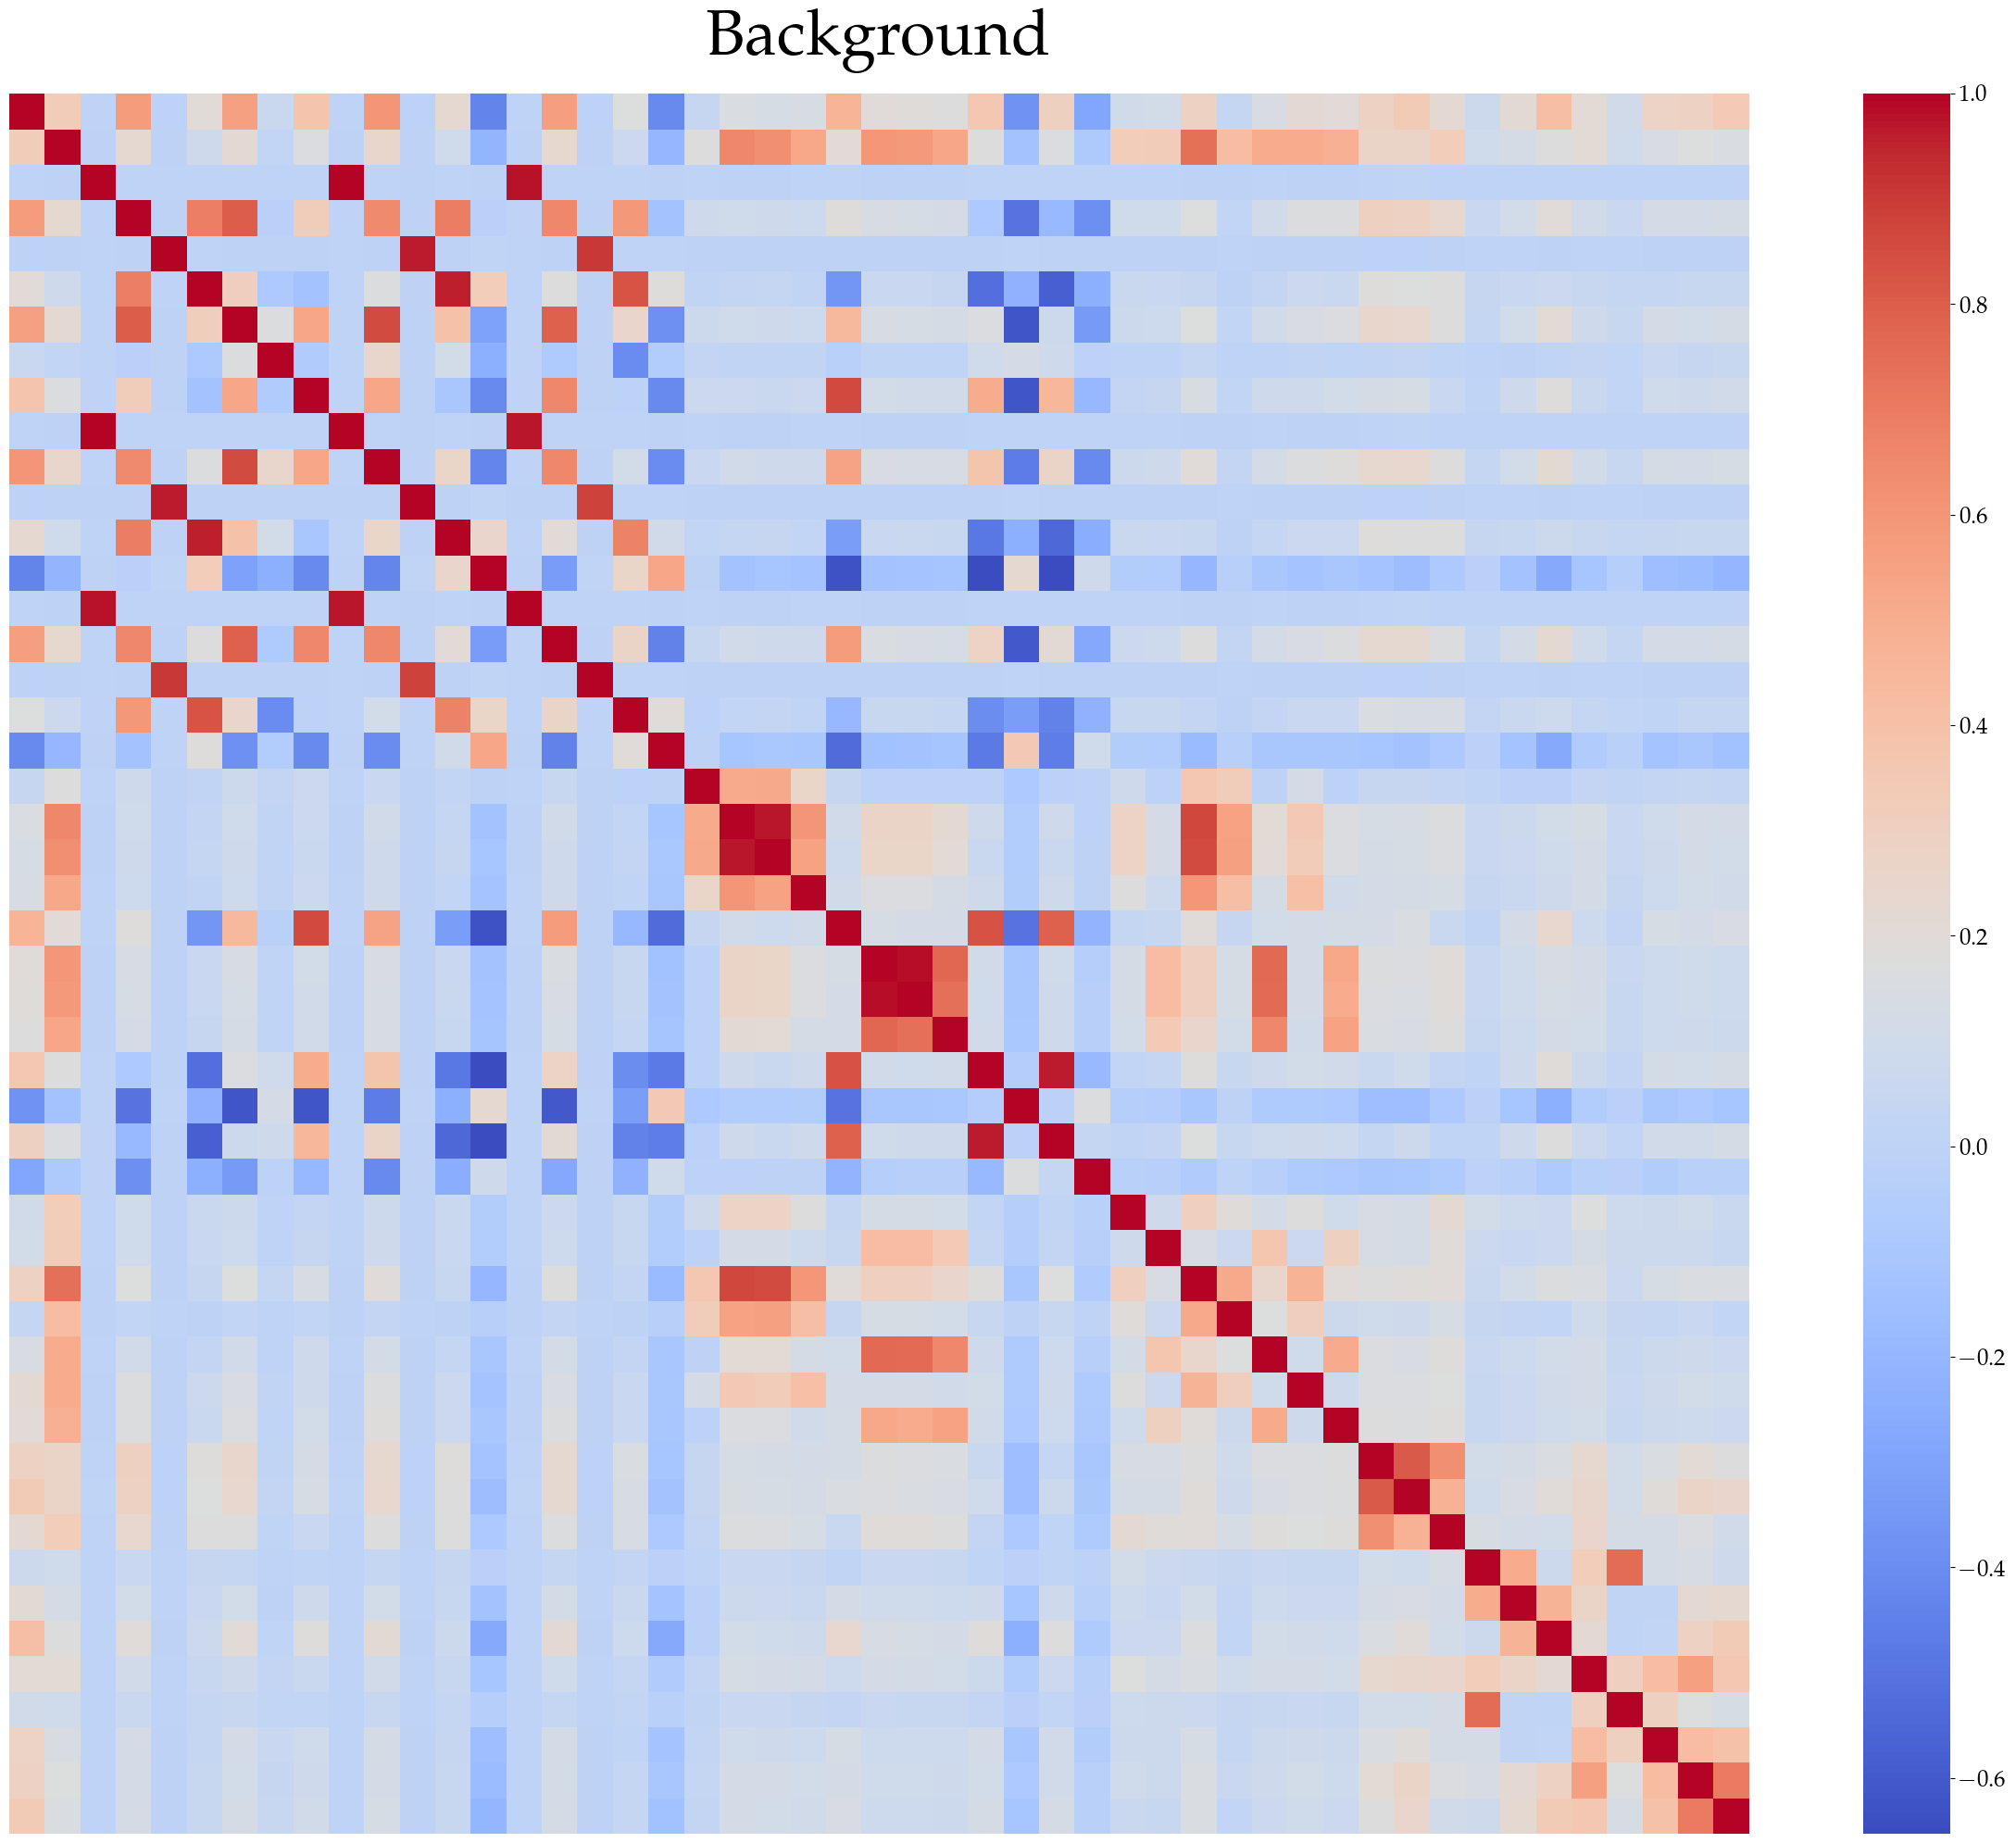

In [16]:
plt.figure(figsize=(25,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True, 
            xticklabels=False, yticklabels=False)
plt.title('Background', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_bkg.pdf', bbox_inches='tight')
plt.show()

# Combine the training signal and background dataframes into one with appropriate labeling columns

In [17]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

# shuffle and extract training feature and label arrays
train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [18]:
del traindata

# Combine the testing signal and background dataframes into one with appropriate labeling columns

In [19]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

# shuffle and extract testing feature and label arrays
test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [20]:
del testdata

# Perform standard scaling on the training and testing arrays

In [21]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 599 ms, sys: 451 ms, total: 1.05 s
Wall time: 1.15 s


# Get the eigenvalues and eigenvectors of the training set covariance matrix

In [22]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

# Sort the eigenvalues and the eigenvecors according to their eigenvalues
# That's essentially what PCA does
# It is transforming the features according to the sorted eigenvector matrix

In [23]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Plot the sorted eigenvalues in decreasing order to see where "big drops"
# We do this to decide how many principal components we want to keep (if we want to use PCA) after performing PCA

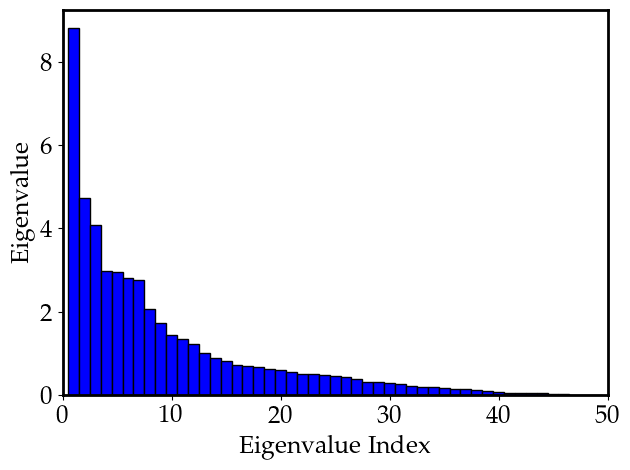

In [24]:
plt.figure()
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.savefig('plots/eigenvalues.pdf')
plt.show()

# Perform PCA

In [25]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[1.79580031e-01 9.67300357e-02 8.34868449e-02 6.05705021e-02
 6.01234754e-02 5.70775426e-02 5.61808507e-02 4.20725658e-02
 3.53641712e-02 2.96308067e-02 2.74963976e-02 2.48308377e-02
 2.07198362e-02 1.81923511e-02 1.64831482e-02 1.46512947e-02
 1.42740518e-02 1.36509841e-02 1.27614092e-02 1.24011768e-02
 1.15194535e-02 1.03838048e-02 1.02747267e-02 1.00546610e-02
 9.19069403e-03 8.69791710e-03 7.74139261e-03 6.42380548e-03
 6.28651312e-03 6.12947123e-03 5.42648758e-03 4.23861802e-03
 4.11487164e-03 3.77978190e-03 3.32074394e-03 3.03892180e-03
 2.75929850e-03 2.42389457e-03 2.07859935e-03 1.24584416e-03
 9.93651424e-04 9.07469741e-04 8.79539657e-04 8.30081749e-04
 3.68419912e-04 2.74495506e-04 1.93836138e-04 8.38842042e-05
 6.08071284e-05]
[0.17958003 0.27631007 0.35979691 0.42036741 0.48049089 0.53756843
 0.59374928 0.63582185 0.67118602 0.70081683 0.72831322 0.75314406
 0.7738639  0.79205625 0.8085394  0.82319069 0.83746474 0.85111573
 0.86387714 0.87627831 0.88779777 0.89818157 0.908

# Plot the cummulative explained variance vs number of principal components
# With this plot we can decide how many principal components we want to keep for dimensionality reduction

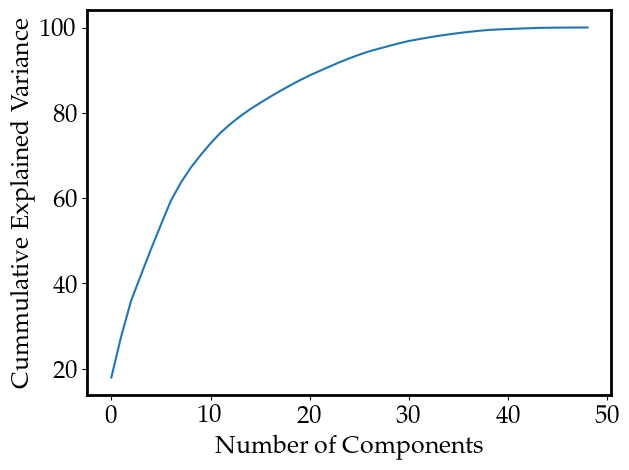

In [26]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.pdf')
plt.show()

# Define function that calculates the divergence between two sets of observations

In [27]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    '''
    This function calculates the divergence between two sets of observations.
    INPUTS:
        feature1, feature2: arrays of observations.
        bins: number of bins when histogramming those arrays.
        eps: small quantity to avoid NaNs in logarithms of Kullback–Leibler divergence.
    OUTPUTS:
        divergence between the distributions of the two arrays.
    
    This function first histograms the data in the same range and bins,
    then it calculates the Kullback–Leibler divergence of feature1 with feature2 and then of feature2 with feature1.
    It adds up the two divergences and returns the "unified" divergence as the output.
    '''
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

# Calculate the divergences between of the distributions of signal and background events for all feature variables
# Print the divergences of each variable in a sorted manner from largest to smallest

In [28]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/49 [00:00<?, ?it/s]

fj_mass                          2.610323
fj_ptDR                          2.350188
fj_tau21                         2.232322
fj_trackSip2dSigAboveBottom_0    1.381715
fj_sdsj2_mass                    1.376652
fj_trackSip2dSigAboveCharm_0     1.170766
fj_sdsj1_mass                    1.160778
fj_sdsj2_pt                      1.143146
fj_sdn2                          1.098077
fj_trackSip2dSigAboveBottom_1    1.056838
fj_trackSipdSig_0                1.009403
fj_pt                            0.985634
fj_tau_flightDistance2dSig_0     0.928369
fj_trackSipdSig_0_0              0.788451
fj_tau_vertexEnergyRatio_0       0.756208
fj_nSV                           0.704349
fj_sdsj1_pt                      0.696240
fj_tau_vertexDeltaR_0            0.603827
fj_trackSipdSig_0_1              0.600189
fj_tau_vertexEnergyRatio_1       0.597590
fj_trackSipdSig_1                0.587649
fj_sdsj2_ptD                     0.563223
fj_tau1                          0.558846
fj_trackSipdSig_2                0

# Histogram the 6 variables with the largest divergence

  0%|          | 0/6 [00:00<?, ?it/s]

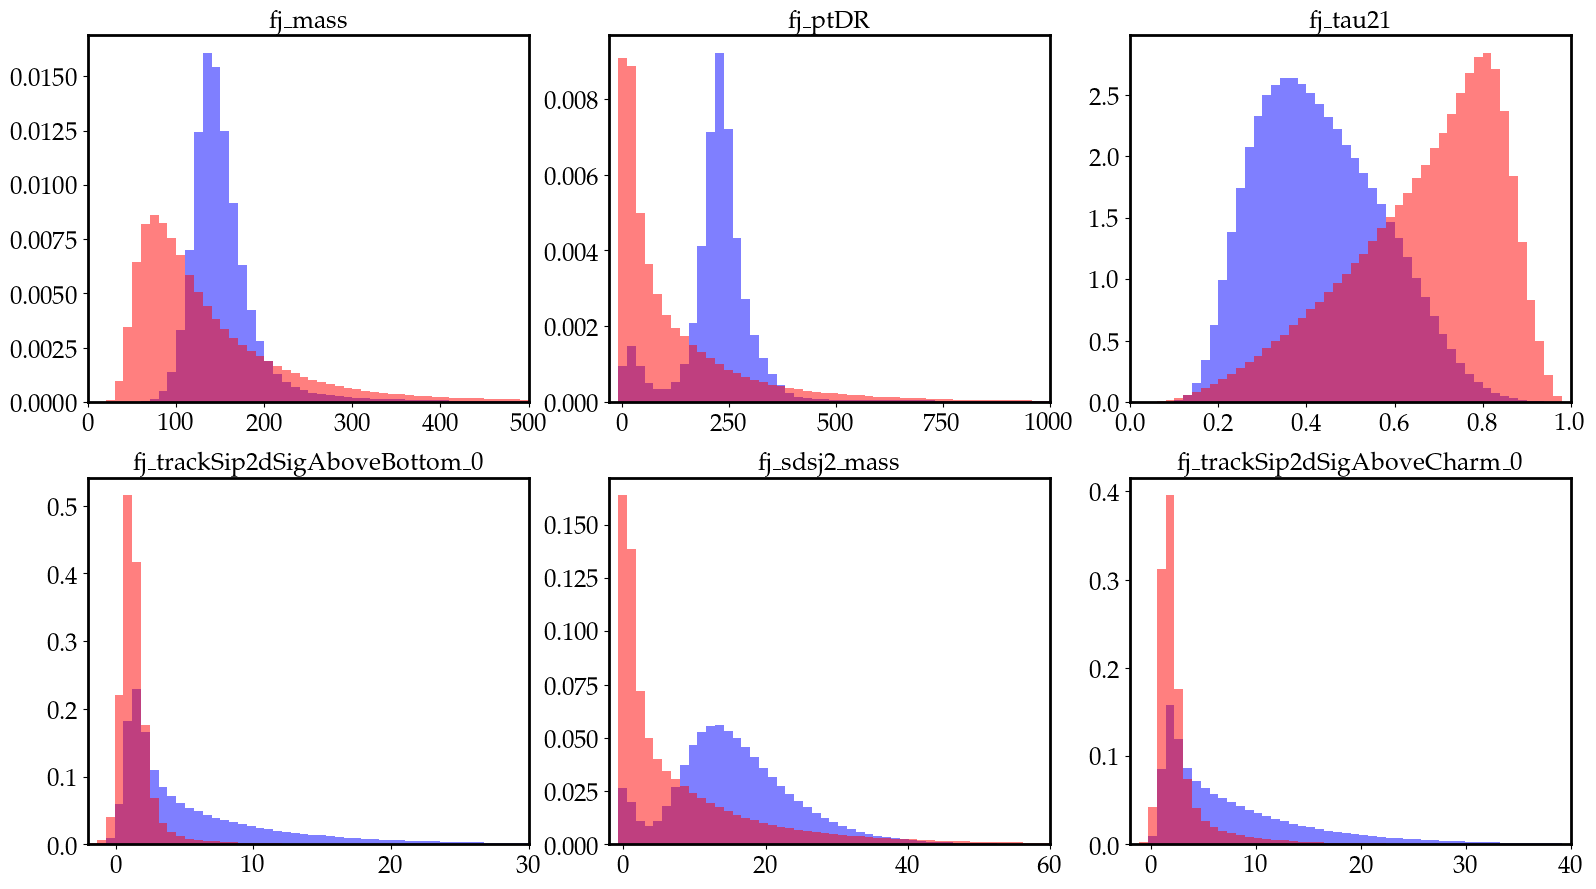

In [29]:
fig, axes = plt.subplots(2,3, figsize=(16,9))

features_to_plot = divergences.index.tolist()[:6]

lims = [(0,500),(-30,1000),(0,1),(-2,30),(-2,60),(-2,40)]

for ax, label, lim in tqdm(zip(axes.ravel(), features_to_plot, lims), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50, range=lim)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50, range=lim)
    ax.set_title(label,fontsize=18)
    ax.set_xlim(lim)
    
plt.tight_layout()
plt.savefig('plots/high_divergence_hists.pdf')
plt.show()

# Define the final training and testing datasets
# We can choose to use PCA transformed datasets or not
# We can also choose to use a specific number of principal components only
# Use only 2 lines of the code accordingly

In [31]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

print(X_train_final.shape)
print(X_test_final.shape)

(3022214, 49)
(989076, 49)


# Save the final feature and label arrays, the names of the used features and the labels into a single npz file
# The name of the file is "train_test_<# of features>variables.npz" and is saved inside the "root_files" folder

In [32]:
np.savez(f'root_files/train_validate_{len(features)}variables.npz', 
         X_train = X_train_final, y_train = y_train, X_test = X_test_final, y_test = y_test,
         variables = features, labels = ['Hbb', 'QCD'])